<a href="https://colab.research.google.com/github/athabrani/DeepLearning/blob/main/UTS_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.preprocessing import label_binarize
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D, GaussianNoise, ActivityRegularization
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
import warnings
from google.colab import drive
import math

warnings.filterwarnings('ignore')


#Load and preparing dataset

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data_dir = '/content/drive/MyDrive/FishImgDataset'
print(os.listdir(data_dir))

['train', 'val', 'test']


In [4]:
train_path = os.path.join(data_dir, 'train')
val_path = os.path.join(data_dir, 'val')
test_path = os.path.join(data_dir, 'test')


def check_fish_list(directory):
    valid = 0
    invalid = 0
    fish_types = []

    print(f"Direktori: {directory}")

    for fish_type in sorted(os.listdir(directory)):
        fish_dir = os.path.join(directory, fish_type)
        if os.path.isdir(fish_dir):
            fish_types.append(fish_type)
            for image_file in os.listdir(fish_dir):
                image_path = os.path.join(fish_dir, image_file)
                try:
                    img = tf.io.decode_image(tf.io.read_file(image_path))
                    valid += 1
                except:
                    invalid += 1
                    print(f"File tidak valid: {image_path}")

    print(f"hasil process: invalid({invalid}) valid({valid})")
    print(f"Jenis ikan ({len(fish_types)} kelas): {', '.join(fish_types)}")
    print("-" * 50)

    return fish_types

# Panggil untuk masing-masing folder
fish_types_train = check_fish_list(train_path)
fish_types_val = check_fish_list(val_path)
fish_types_test = check_fish_list(test_path)

Direktori: /content/drive/MyDrive/FishImgDataset/train
File tidak valid: /content/drive/MyDrive/FishImgDataset/train/Silver Perch/silver perch (1).webp
File tidak valid: /content/drive/MyDrive/FishImgDataset/train/Silver Perch/silver perch (4).webp
hasil process: invalid(2) valid(8819)
Jenis ikan (31 kelas): Bangus, Big Head Carp, Black Spotted Barb, Catfish, Climbing Perch, Fourfinger Threadfin, Freshwater Eel, Glass Perchlet, Goby, Gold Fish, Gourami, Grass Carp, Green Spotted Puffer, Indian Carp, Indo-Pacific Tarpon, Jaguar Gapote, Janitor Fish, Knifefish, Long-Snouted Pipefish, Mosquito Fish, Mudfish, Mullet, Pangasius, Perch, Scat Fish, Silver Barb, Silver Carp, Silver Perch, Snakehead, Tenpounder, Tilapia
--------------------------------------------------
Direktori: /content/drive/MyDrive/FishImgDataset/val
hasil process: invalid(0) valid(2751)
Jenis ikan (31 kelas): Bangus, Big Head Carp, Black Spotted Barb, Catfish, Climbing Perch, Fourfinger Threadfin, Freshwater Eel, Glass Pe

In [5]:

fish_types = [d for d in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, d))]

# Fungsi menghitung jumlah sampel per kelas
def get_class_distribution(directory, fish_types):
    distribution = {}
    for fish_type in fish_types:
        fish_dir = os.path.join(directory, fish_type)
        if os.path.isdir(fish_dir):
            count = len(os.listdir(fish_dir))
            distribution[fish_type] = count
    return distribution

# Hitung distribusi
train_distribution = get_class_distribution(train_path, fish_types)
val_distribution = get_class_distribution(val_path, fish_types)
test_distribution = get_class_distribution(test_path, fish_types)

# Buat DataFrame untuk visualisasi
df_distribution = pd.DataFrame({
    'Train': train_distribution,
    'Validation': val_distribution,
    'Test': test_distribution
})

print("Distribusi kelas per split dataset:")
print(df_distribution)


Distribusi kelas per split dataset:
                       Train  Validation  Test
Silver Perch             285          88    57
Scat Fish                154          48    33
Tenpounder               277          87    56
Pangasius                193          61    38
Snakehead                232          72    47
Silver Carp              238          75    48
Tilapia                  302          95    57
Silver Barb              329         105    64
Perch                    293          91    60
Indo-Pacific Tarpon      186          57    39
Knifefish                319         100    65
Mosquito Fish            256          80    51
Jaguar Gapote            229          72    44
Indian Carp              262          81    53
Green Spotted Puffer     110          34    22
Long-Snouted Pipefish    256          81    52
Mudfish                  191          60    34
Mullet                   174          55    38
Janitor Fish             286          89    58
Black Spotted Barb      

#Preprocessing Data

In [6]:
image_size = 64
batch = 32

train_data = ImageDataGenerator(
    rescale=1./255,
    rotation_range= 20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    brightness_range=[0.7, 1.1],
    channel_shift_range=10,
    fill_mode='reflect'
)


val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_data.flow_from_directory(
    train_path,
    target_size=(image_size, image_size),
    batch_size= batch,
    class_mode='categorical',
    shuffle=True
)

valid_gen = val_datagen.flow_from_directory(
    val_path,
    target_size=(image_size, image_size),
    batch_size=batch,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(image_size, image_size),
    batch_size=batch,
    class_mode='categorical',
    shuffle=False
)


class_mapping = train_gen.class_indices
class_names = list(class_mapping.keys())
num_classes = len(class_names)

Found 8801 images belonging to 31 classes.
Found 2751 images belonging to 31 classes.
Found 1760 images belonging to 31 classes.



Contoh gambar dari training set:


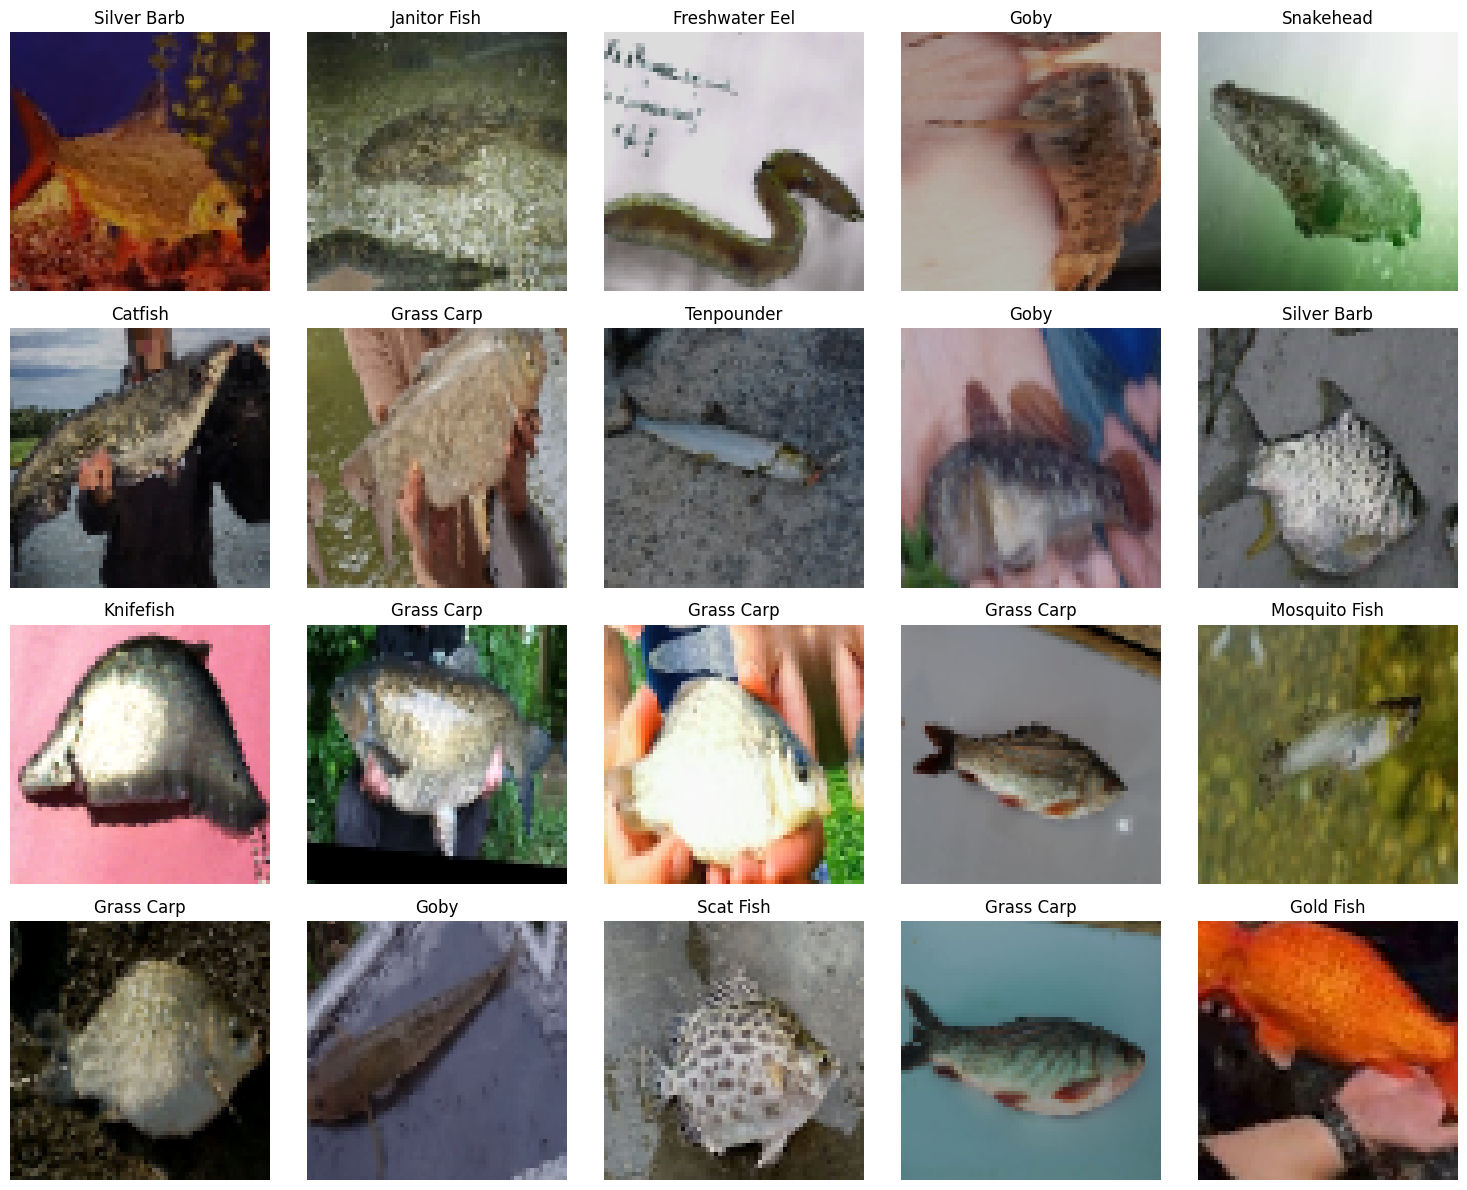

In [7]:
def visualize_samples(generator, n=15):
    batch = next(generator)
    images, labels = batch

    rows = math.ceil(n / 5)  # Ubah 5 menjadi berapa banyak kolom yang diinginkan
    cols = min(n, 5)

    plt.figure(figsize=(cols * 3, rows * 3))  # Sesuaikan ukuran per gambar

    for i in range(min(n, len(images))):
        ax = plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i])
        label_idx = np.argmax(labels[i])
        class_name = list(generator.class_indices.keys())[label_idx]
        plt.title(class_name)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

print("\nContoh gambar dari training set:")
visualize_samples(train_gen, n=20)

In [8]:
def eval_metrics(y_true, y_pred, y_prob, num_classes=num_classes):
    y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)
    # Menghitung metrik evaluasi
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    auc_score = roc_auc_score(y_true_one_hot, y_prob, average='macro', multi_class='ovr')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc_score
    }

In [9]:
def visualize_results(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

def visualize_roc_curve(y_true, y_scores):

    n_classes = y_scores.shape[1]
    y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])


    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_scores.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure(figsize=(8, 6))
    plt.plot(fpr[1], tpr[1], label=f'ROC curve (area = {roc_auc[1]:.2f})')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig('roc_curve.png')
    plt.show()

def visualize_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    plt.matshow(cm, cmap='Blues', fignum=1)
    plt.colorbar()
    plt.title('Confusion Matrix')

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, f'{cm[i, j]}', ha='center', va='center', color='white' if cm[i, j] > cm.max() / 2 else 'black')

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks(range(num_classes), class_names, rotation=90, fontsize=8)
    plt.yticks(range(num_classes), class_names, fontsize=8)
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()


#Model CNN

In [10]:
#Model CNN Mods
def cnn_model(input_shape=(image_size, image_size, 3), num_classes=num_classes):
    # Inisialisasi model
    model = Sequential([

        Input(shape=input_shape),

        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(256, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

# Inisialisasi model
model_cnn = cnn_model()

In [11]:
model = cnn_model()  # Bisa diganti dengan create_custom_cnn_model() untuk model CNN custom
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Ringkasan model
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 31)             │        15,903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,779,679 (33.49 MB)

 Trainable params: 8,777,759 (33.48 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [12]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_regularized_model.keras',
    save_best_only=True
)

callbacks = [model_checkpoint, early_stopping, reduce_lr]

steps_per_epoch = len(train_gen)
validation_steps = len(valid_gen)

model_cnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Training model
print("Training Model")
history = model_cnn.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=100,
    batch_size=batch,
    validation_data=valid_gen,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

Training Model
Epoch 1/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 490s 2s/step - accuracy: 0.1511 - loss: 3.7738 - val_accuracy: 0.0462 - val_loss: 4.8783 - learning_rate: 0.0010
Epoch 2/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 503s 2s/step - accuracy: 0.2389 - loss: 3.0346 - val_accuracy: 0.3257 - val_loss: 2.4307 - learning_rate: 0.0010
Epoch 3/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 530s 2s/step - accuracy: 0.3036 - loss: 2.6039 - val_accuracy: 0.3010 - val_loss: 2.7256 - learning_rate: 0.0010
Epoch 4/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 482s 2s/step - accuracy: 0.3679 - loss: 2.2947 - val_accuracy: 0.4540 - val_loss: 1.8658 - learning_rate: 0.0010
Epoch 5/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 500s 2s/step - accuracy: 0.4009 - loss: 2.1124 - val_accuracy: 0.3711 - val_loss: 2.4707 - learning_rate: 0.0010
Epoch 6/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 479s 2s/step - accuracy: 0.4400 - loss: 1.9726 - val_accuracy: 0.4675 - val_loss: 2.0377 - learning_rate: 0.0010
Epoch 7/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 488s 2s/step - accur

#Evaluate model

In [13]:
test_loss, test_accuracy = model_cnn.evaluate(test_generator, verbose=1)
print(f"Test accuracy: {test_accuracy:.4f}")

# Konversi dataset untuk evaluasi metrik lengkap
y_test = []
y_pred = []
y_pred_proba = []

# Menghitung prediksi untuk semua data uji
for i in range(len(test_generator)):
    x_batch, y_batch = test_generator[i]
    y_test.extend(np.argmax(y_batch, axis=1))
    y_pred_prob = model_cnn.predict(x_batch, verbose=0)
    y_pred.extend(np.argmax(y_pred_prob, axis=1))
    y_pred_proba.extend(y_pred_prob)

# Mengonversi ke numpy array
y_test = np.array(y_test)
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

# Menghitung metrik evaluasi
results = eval_metrics(y_test, y_pred, y_pred_proba)

# Output metrik evaluasi
print("Hasil evaluasi model:")
print(f"Accuracy: {results['accuracy']:.4f}")
print(f"Precision: {results['precision']:.4f}")
print(f"Recall: {results['recall']:.4f}")
print(f"F1 Score: {results['f1']:.4f}")
print(f"AUC: {results['auc']:.4f}")

print(classification_report(y_test, y_pred, target_names=class_names))



55/55 ━━━━━━━━━━━━━━━━━━━━ 31s 563ms/step - accuracy: 0.8613 - loss: 0.4708
Test accuracy: 0.8790
Hasil evaluasi model:
Accuracy: 0.8790
Precision: 0.8852
Recall: 0.8790
F1 Score: 0.8791
AUC: 0.9947
                       precision    recall  f1-score   support

               Bangus       0.79      0.79      0.79        34
        Big Head Carp       0.91      0.70      0.79        43
   Black Spotted Barb       0.85      0.85      0.85        40
              Catfish       0.80      0.90      0.85        62
       Climbing Perch       0.88      0.73      0.80        30
 Fourfinger Threadfin       0.90      0.74      0.81        38
       Freshwater Eel       0.91      0.87      0.89        55
       Glass Perchlet       0.93      0.91      0.92        77
                 Goby       0.93      0.84      0.88       124
            Gold Fish       1.00      1.00      1.00        41
              Gourami       1.00      0.98      0.99        63
           Grass Carp       0.94      0.97  

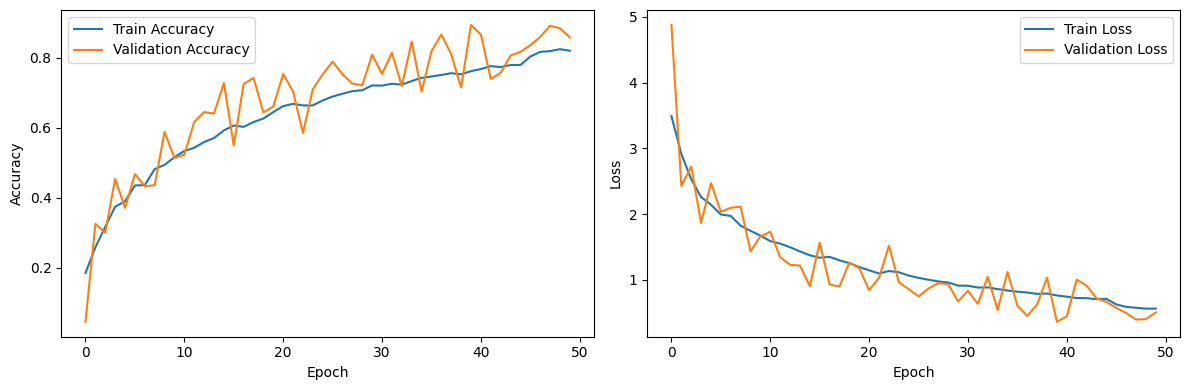

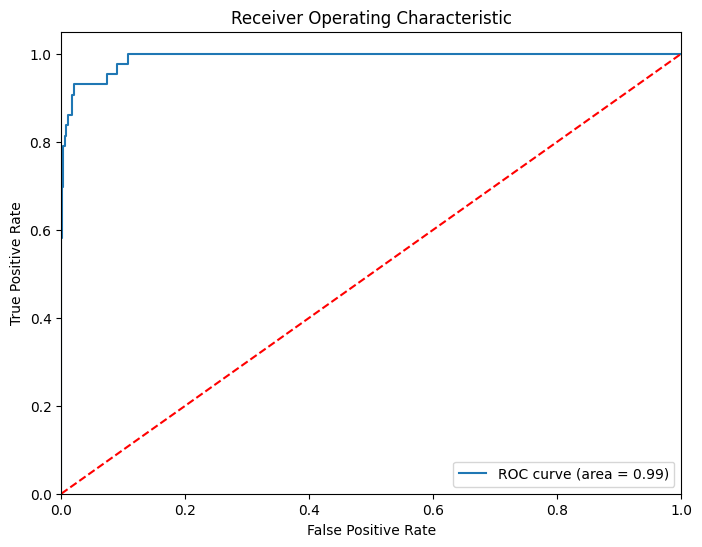

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

<Figure size 1200x1000 with 0 Axes>

In [14]:
visualize_results(history)
visualize_roc_curve(y_test, y_pred_proba)
visualize_confusion_matrix(y_test, y_pred)
